# Accuracy versus energy
Goals=Compare energy consumed versus learning advancement.

No information on training accuracy, only evaluations.

ToDo:
- compute total energy timeserie
- plot in parallel with accuracy
- compute energy between each eval

In [1]:
import pandas as pd
# import modin.pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

logs = "/Users/mathildepro/Documents/code_projects/logs/Apollo"
graph_dir = f"{logs}/graphs/accuracy"
processed_log_dir = f"{logs}/resultats_11-23_processed"
log_dir = f"{logs}/resultats_11-23/"
save_dir = f"{processed_log_dir}/resnet/"
path = f"{log_dir}/resnet/"

job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"

# energy = dd.read_csv(
#     energy_file, 
#     dtype={'cpu': 'object', 'socket': 'object', 'domain': 'object'}).drop(columns=["Unnamed: 0"])
# energy.to_parquet(save_dir+'energy.parquet', engine='pyarrow')
energy = dd.read_parquet(save_dir+'energy.parquet', engine='pyarrow')
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])


In [2]:
jobs = jobs[jobs["job"]>126990]
jobs[:1]

,job,energy_kWh,energy_joule,energy_consumption_since_previous_measurement_milliJ,job_id,file,start_time_ms,sub_seed,sub_batch-size,sub_num-sample,...,mllog_lars_opt_base_learning_rate,mllog_lars_opt_learning_rate_warmup_epochs,mllog_lars_opt_learning_rate_decay_steps,mllog_train_samples,mllog_eval_samples,mllog_tracked_stats,mllog_throughput,mllog_eval_accuracy,srun_start_time_ms,node_nb
5,127007,1.644348,5.919654e+06,5.919654e+09,127007,/Users/mathildepro/Documents/code_projects/hpe...,1.699634e+12,51,408.0,NaN,...,10.5,2,37,1281167,50000,{'imgs_sec': 27181.905681526103},27181.905682,0.76158,NaN,1


In [3]:
job = 127007
plot_df = jobs[(jobs["job"]==job)]

In [4]:
file = plot_df.file.values[0]
file.split("/")[-2:]

['127007', '231110173109169586574_1.log']

In [6]:
import sys
sys.path.append("../../logging/mlperf_logging/")
from compliance_checker.mlp_parser import parse_file


log_file = path + "/".join(file.split("/")[-2:])
print(log_file)

loglines, _ = parse_file(log_file, ruleset="2.1.0")
mllog = pd.json_normalize(pd.DataFrame(loglines)["value"])
mllog = mllog.merge(pd.DataFrame(loglines)[["timestamp", "key"]], left_index=True, right_index=True)

/Users/mathildepro/Documents/code_projects/logs/Apollo/resultats_11-23//resnet/127007/231110173109169586574_1.log


In [7]:
mllog = mllog.drop(['metadata.file', 'metadata.lineno', 'metadata.tensor', 'metadata.status'], axis=1)

In [8]:
pd.set_option('display.max_colwidth', 15)
pd.set_option('display.max_rows', 67)
table = mllog[mllog["value"].notna()].dropna(axis=1,how='all')
cols = [x for x in table.columns] # if (x != "full_string") and (x != "metadata")]
table[cols].style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

,value,metadata.epoch_num,timestamp,key
0,resnet,nan,1699633922229.000000,submission_benchmark
1,HPE,nan,1699633922236.000000,submission_org
2,closed,nan,1699633922236.000000,submission_division
3,onprem,nan,1699633922236.000000,submission_status
4,1xHPE-ProLiant-XL675d-Gen10-Plus,nan,1699633922236.000000,submission_platform
13,51,nan,1699633938257.000000,seed
14,408,nan,1699633944627.000000,model_bn_span
177,2,nan,1699633950793.000000,sgd_opt_learning_rate_decay_poly_power
178,0.000100,nan,1699633950795.000000,sgd_opt_end_learning_rate
179,2,nan,1699633950795.000000,lars_opt_learning_rate_decay_poly_power


Text(0, 0.5, 'Accuracy')

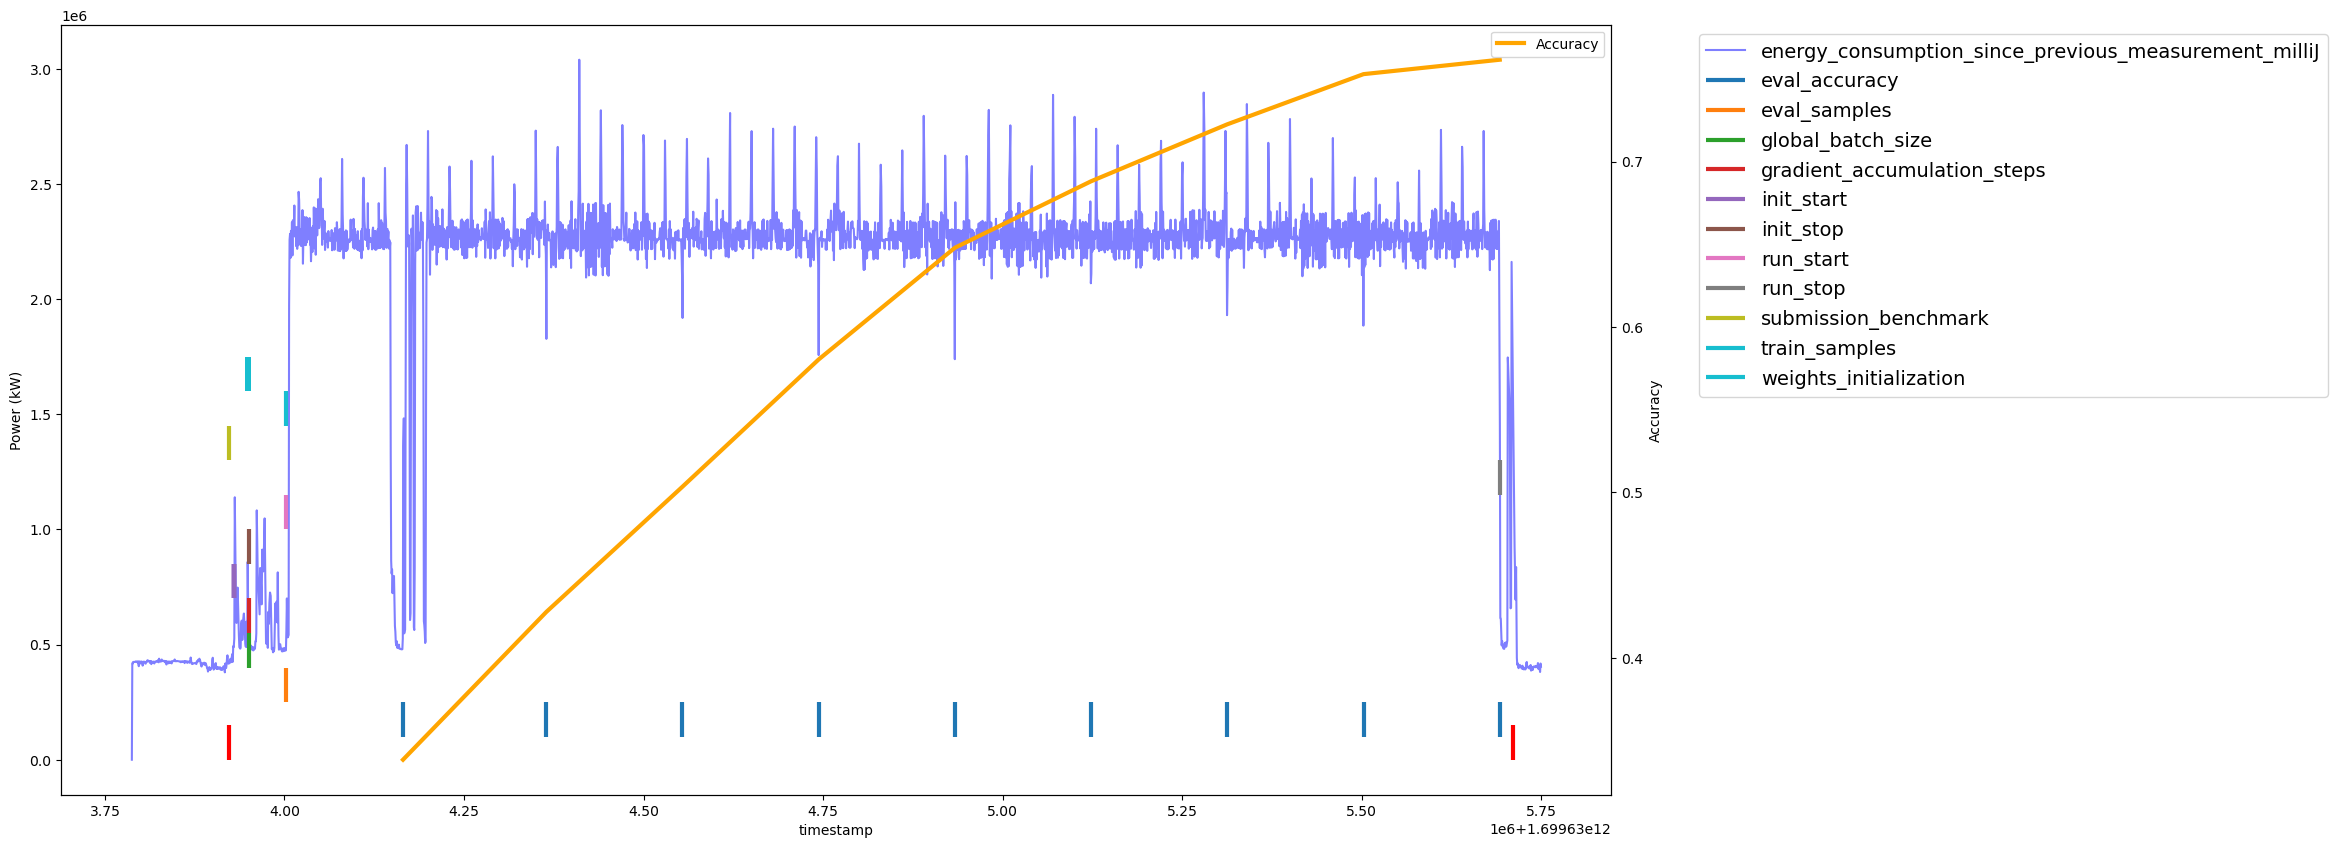

In [9]:
import itertools
import numpy as np
keys = ['eval_accuracy', 'eval_samples', 'global_batch_size',
       'gradient_accumulation_steps', 'init_start', 'init_stop',
       'run_start', 'run_stop', 
       'submission_benchmark', #'submission_division', 'submission_org', 'submission_platform','submission_status', 
       'train_samples', 'weights_initialization']

fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twinx()
energy[energy["job"]==job].sort_values(by="timestamp").groupby("timestamp")[["energy_consumption_since_previous_measurement_milliJ"]].sum().compute().plot(ax=ax,y="energy_consumption_since_previous_measurement_milliJ", color="blue", alpha=0.5)
ax.set_ylabel("Power (kW)")

COLOR = plt.cm.tab10
iter = itertools.cycle(COLOR(np.linspace(0, 1, len(keys))))
ymin = 1e5
size = 1.5e5
for key in keys:
    color = next(iter)
    ax.vlines(x=mllog[mllog["key"]==key]["timestamp"], ymin=ymin, ymax=ymin+size, color=color, linewidth=3, label=key)
    ymin+=size
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)

ax.vlines(x=jobs[jobs["job"]==job]["start_time_ms"], ymin=0, ymax=size, color="red", linewidth=3, label="Accuracy")
ax.vlines(x=jobs[jobs["job"]==job]["end_time_ms"], ymin=0, ymax=size, color="red", linewidth=3, label="Accuracy")

mllog[mllog["key"]=="eval_accuracy"][["timestamp", "value"]].plot(ax=ax2,x="timestamp", y="value", label="Accuracy", color="orange", linewidth=3)
ax2.set_ylabel("Accuracy")



# For all jobs

In [10]:
def compute_energy_between_accuracies(row):
        """Compute energy between two accuracy values."""
        mask = (energy["timestamp"]>=row["timestamp"]-row["time_diff"])&(energy["timestamp"]<=row["timestamp"])
        energy_between_accuracies = energy[mask]["energy_kWh"].sum().compute()
        return energy_between_accuracies

accuracy_df = pd.DataFrame()
range_df = pd.DataFrame()

for job in jobs["job"].unique()[-10:]:
    file = jobs[jobs["job"]==job]["file"].values[0]
    file.split("/")[-2:]    
    log_file = path + "/".join(file.split("/")[-2:])

    loglines, _ = parse_file(log_file, ruleset="2.1.0")
    mllog = pd.json_normalize(pd.DataFrame(loglines)["value"])
    mllog = mllog.merge(pd.DataFrame(loglines)[["timestamp", "key"]], left_index=True, right_index=True)

    acc_df = mllog[mllog["key"]=="eval_accuracy"][["timestamp", "value"]].reset_index(drop=True)
    acc_df["time_diff"] = acc_df["timestamp"].diff()
    acc_df["acc_diff"] = acc_df["value"].diff()
    acc_df.rename(columns={"value":"accuracy"}, inplace=True)
    acc_df.at[0, "acc_diff"] = acc_df.at[0, "accuracy"]
    first_timestamp = acc_df.at[0, "timestamp"]
    run_start = mllog[mllog["key"]=='run_start']["timestamp"].values[0]
    acc_df.at[0, "time_diff"] = first_timestamp - run_start
    acc_df["energy_kWh"] = acc_df.apply(compute_energy_between_accuracies, axis=1)
    acc_df["energy_kWh_cumsum"] = acc_df["energy_kWh"].cumsum()
    acc_df.loc[len(acc_df)] = None
    acc_df = acc_df.shift(1).fillna(0)
    acc_df["job"] = job
    
    range_acc = [x / 100 for x in range(30, 78, 1)]
    rg_df = pd.concat([pd.DataFrame({"accuracy":range_acc}), acc_df[["accuracy", "energy_kWh_cumsum", "timestamp"]]]).sort_values(by="accuracy").interpolate()
    rg_df = rg_df[rg_df["accuracy"].isin(range_acc)]
    rg_df["job"] = job
    
    accuracy_df = pd.concat([accuracy_df, acc_df])
    range_df = pd.concat([range_df, rg_df])

In [11]:
range_df

,accuracy,energy_kWh_cumsum,timestamp,job
0,0.30,0.045733,5.667461e+11,127755
1,0.31,0.091465,1.133492e+12,127755
2,0.32,0.151144,1.700238e+12,127755
3,0.33,0.165090,1.700238e+12,127755
4,0.34,0.179036,1.700238e+12,127755
...,...,...,...,...
43,0.73,1.195074,1.700257e+12,127764
44,0.74,1.315885,1.700257e+12,127764
45,0.75,1.496962,1.700258e+12,127764
46,0.76,1.587407,1.700258e+12,127764


In [12]:
accuracy_job = accuracy_df.merge(jobs, on="job", how="left")

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

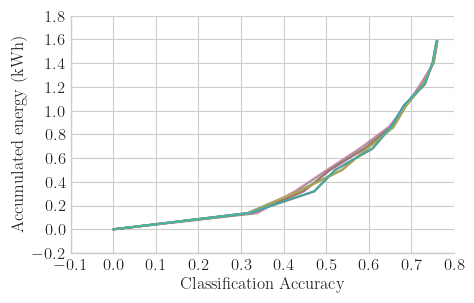

In [13]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-whitegrid')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

plt.figure(figsize=(15,8))
ax = sns.relplot(
    x="accuracy", y="energy_kWh_cumsum",
    data=accuracy_job, 
    hue="job", kind="line", 
    palette="tab10",
    height=3, aspect=12/8,alpha=0.7,
    )# ax.set(title="Power consumption of dlrm training")
ax._legend.remove()
FONTSIZE = 12
ax.set_xlabels("Classification Accuracy", fontsize=FONTSIZE)
ax.set_ylabels("Accumulated energy (kWh)", fontsize=FONTSIZE)
ax.set_xticklabels(fontsize=FONTSIZE)
ax.set_yticklabels(fontsize=FONTSIZE)
ax.savefig(f"{graph_dir}/resnet.pdf", dpi=300)

In [ ]:
range_df = pd.concat([range_df, pd.DataFrame({"accuracy":0, "energy_kWh_cumsum":0, "job":0, "timetamp":0}, index=[0])])

In [ ]:
apollo_df = range_df[["accuracy", "energy_kWh_cumsum", "timestamp"]].groupby("accuracy").mean().reset_index() # accuracy_df

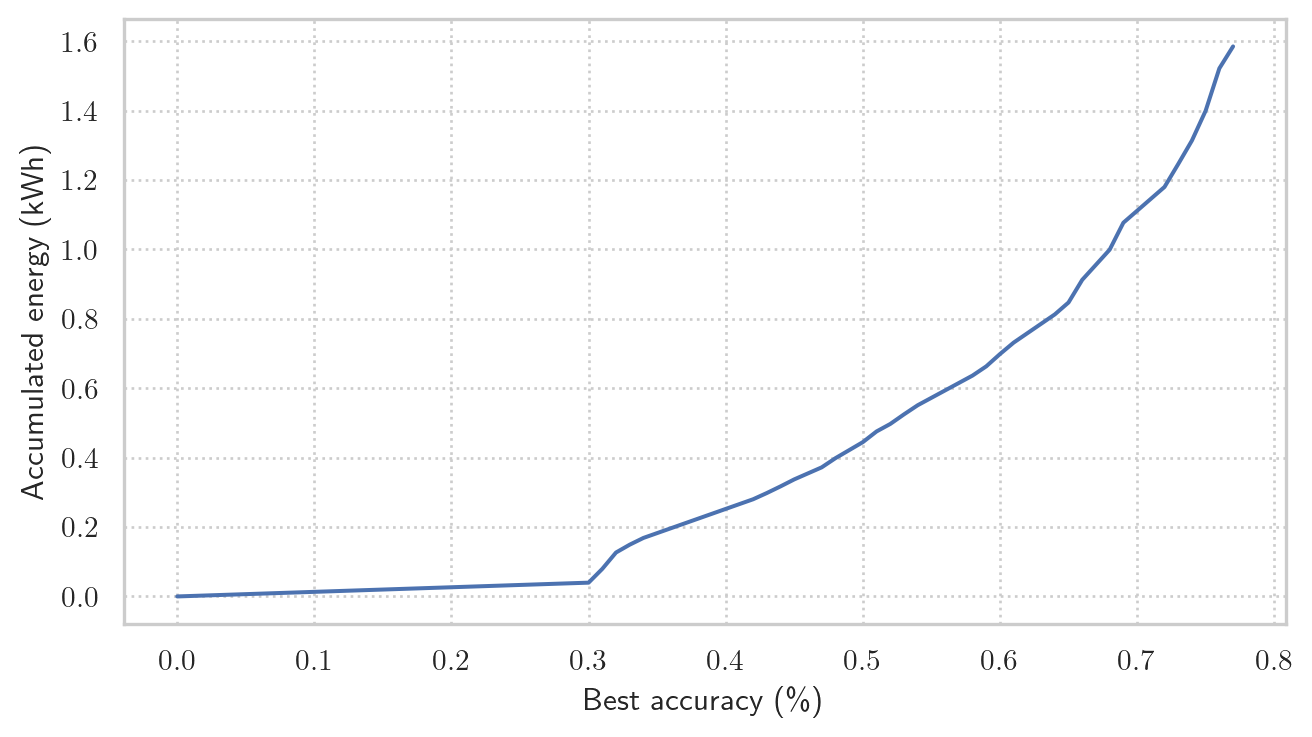

In [ ]:
import seaborn.objects as so
from seaborn import axes_style
theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}

f = plt.Figure(figsize=(7, 4))
(
    so.Plot(range_df.reset_index(), x="accuracy", y="energy_kWh_cumsum")
    .add(so.Line(), so.Agg())
    .scale(color="colorblind")
    .on(f)
    .theme(theme_dict)
    .label(
        x="Best accuracy (\%)",
        y = "Accumulated energy (kWh)",
        color=None,
    )
    .layout(engine="tight")
    # .layout(engine="constrained")
)

In [ ]:
ax.savefig(f"{graph_dir}/resnet.png", dpi=300)

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


,Unnamed: 0,index,step,timestamp,accuracy,phase,datetime,Best_accuracy,energy_cumsum
0,0,0,1,1.721734e+09,0.100000,Test,2024-07-23 ...,0.100000,0.000000
1,1,1,501,1.721737e+09,0.266000,Test,2024-07-23 ...,0.266000,0.000000
2,2,2,1001,1.721740e+09,0.934000,Test,2024-07-23 ...,0.934000,0.000000
3,3,3,1501,1.721742e+09,2.660000,Test,2024-07-23 ...,2.660000,0.013586
4,4,4,2001,1.721745e+09,5.372000,Test,2024-07-23 ...,5.372000,0.042690
...,...,...,...,...,...,...,...,...,...
104,104,104,46711,1.721999e+09,55.058002,Test,2024-07-26 ...,55.100002,2.652637
105,105,105,46712,1.722000e+09,41.948002,Test,2024-07-26 ...,55.100002,2.656656
106,106,106,47212,1.722002e+09,54.518002,Test,2024-07-26 ...,55.100002,2.685261
107,107,107,47712,1.722005e+09,54.758003,Test,2024-07-26 ...,55.100002,2.714788


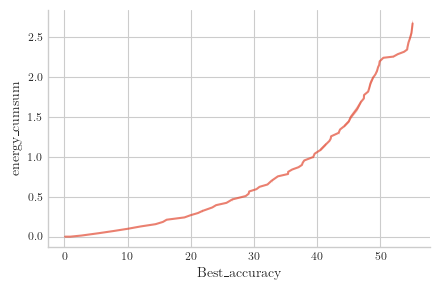

In [ ]:
log_dir = "/Users/mathildepro/Documents/code_projects/logs/Jetson/logs"
jetson = pd.read_csv(log_dir + "/20240723_132409/" + "tb_energycumsum.csv")
ax = sns.relplot(
    x="Best_accuracy", y="energy_cumsum",
    data=jetson, 
    kind="line", 
    # palette="colorbl",
    height=3, aspect=12/8,alpha=0.7,
    )
jetson

In [ ]:
apollo_df["infra"]="Apollo"
apollo_df["accuracy"] = apollo_df["accuracy"]*100

In [ ]:
jetson_df = jetson[["Best_accuracy", "energy_cumsum", "timestamp"]].rename(columns={"Best_accuracy":"accuracy", "energy_cumsum":"energy_kWh_cumsum"})
jetson_df["infra"]="Jetson"
jetson_df["job"]=0

In [ ]:
df = pd.concat([apollo_df, jetson_df]).reset_index(drop=True)

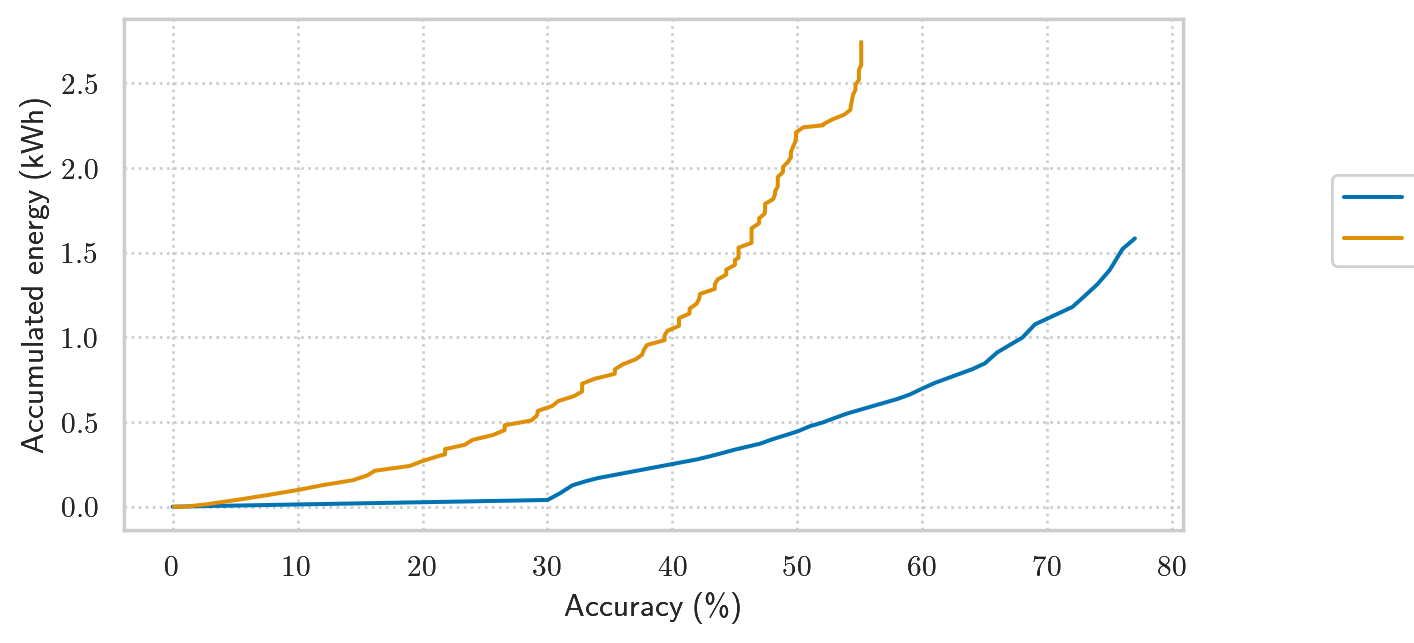

In [ ]:
import seaborn.objects as so
from seaborn import axes_style
graph_dir = "/Users/mathildepro/Documents/code_projects/thèse"
theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}

f = plt.Figure(figsize=(7, 4))
(
    so.Plot(df, x="accuracy", y="energy_kWh_cumsum", color="infra")
    .add(so.Line())
    .scale(color="colorblind")
    .on(f)
    .theme(theme_dict)
    .label(
        x="Accuracy (\%)",
        y = "Accumulated energy (kWh)",
        color=None,
    )
    .layout(engine="tight")
    .save(graph_dir + "/accuracy_energy.pdf", 
          bbox_inches='tight', dpi=300, 
          edgecolor=None,)
    # .layout(engine="constrained")
)

In [ ]:
jetson_df["accuracy"].max()

55.10000228881836

In [ ]:
(72-69.1)/2.6


1.1153846153846176

In [ ]:
apollo_df

,accuracy,energy_kWh_cumsum,timestamp,infra
0,0.0,0.000000,NaN,Apollo
1,30.0,0.039721,4.930717e+11,Apollo
2,31.0,0.079441,9.861434e+11,Apollo
3,32.0,0.126597,1.479215e+12,Apollo
4,33.0,0.149188,1.632237e+12,Apollo
5,34.0,0.168610,1.700247e+12,Apollo
6,35.0,0.182541,1.700247e+12,Apollo
7,36.0,0.196472,1.700247e+12,Apollo
8,37.0,0.210403,1.700247e+12,Apollo
9,38.0,0.224334,1.700247e+12,Apollo


In [ ]:
apollo_df[apollo_df["accuracy"]==apollo_df["accuracy"].values[26]]["energy_kWh_cumsum"].values[0]

0.5723368444445528

In [ ]:
jetson_df[jetson_df["accuracy"]==jetson_df["accuracy"].max()]["energy_kWh_cumsum"].values[0]

2.609440928573213

In [ ]:
# Durées

In [ ]:
accuracy_job["start_time_ms"].unique().mean()

1700246983400.0

In [ ]:
max_timestamp = apollo_df[apollo_df["accuracy"]==apollo_df["accuracy"].values[26]]["timestamp"].values[0]
(max_timestamp - accuracy_job["start_time_ms"].unique().mean())/1000/60/60

0.18765592108832466